In [62]:

from splat.read_colmap import read_images_text, qvec2rotmat
from splat.scene import GaussianScene
import pycolmap
import torch 
import torch.nn as nn
import numpy as np

reconstruction = pycolmap.Reconstruction("/Users/derek/Desktop/colmap/gerrard-hall/sparse/0")

points3d = reconstruction.points3D
images = read_images_text("/Users/derek/Desktop/colmap/gerrard-hall/sparse/images.txt")
cameras = reconstruction.cameras

all_points3d = []
all_point_colors = []
for point in points3d.values():
    # I would assume this is seeing it from multiple images
    if point.track.length() >= 5:
        all_points3d.append(point.xyz)
        all_point_colors.append(point.color / 256)
        
scene = GaussianScene(torch.Tensor(np.array(all_points3d)[:5]), torch.Tensor(np.array(all_point_colors)))

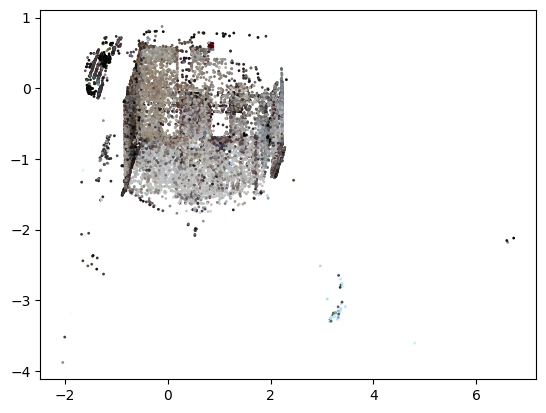

In [66]:
# plot the x and y components of all_points3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.array(all_points3d)[:, 0], np.array(all_points3d)[:, 1], c=all_point_colors, s=1)
plt.show()

In [65]:
all_points3d[:, 0]

TypeError: list indices must be integers or slices, not tuple

In [48]:
# project all points to 2d
from splat.utils import get_intrinsic_matrix, get_extrinsic_matrix

image_num = 14

fx, fy, cx, cy = cameras[1].params[:4]
intrinsic_homogeneous = get_intrinsic_matrix(fx, fy, cx, cy)
image_qvec = images[image_num].qvec
image_tvec = images[image_num].tvec
image_rotation_matrix = qvec2rotmat(image_qvec)
image_translation = torch.Tensor(image_tvec)
extrinsic_matrix = get_extrinsic_matrix(image_rotation_matrix, image_translation)

points, z, covariances = scene.get_points_and_covariance(extrinsic_matrix=extrinsic_matrix, intrinsic_matrix=intrinsic_homogeneous)

In [54]:
camera_coord_points = torch.concatenate([points, z], dim=1)
three_dim_cov = scene.get_3d_covariance_matrix()

In [56]:
intrinsic_matrix = intrinsic_homogeneous

fx = intrinsic_matrix[0, 0]
fy = intrinsic_matrix[1, 1]
W = extrinsic_matrix[:3, :3].transpose(0, 1)
camera_coords_x = camera_coord_points[:, 0]
camera_coords_y = camera_coord_points[:, 1]
camera_coords_z = camera_coord_points[:, 2]
jacobian = torch.zeros((3, 3))
jacobian[0, 0] = (fx.item() / camera_coords_z)[0]
jacobian[1, 1] = (fy.item() / camera_coords_z)[0]
jacobian[0, 2] = -(fx.item() * camera_coords_x / (camera_coords_z ** 2))[0]
jacobian[1, 2] = (fy.item() * camera_coords_y / (camera_coords_z ** 2))[0]

variance = jacobian @ W @ three_dim_cov @ W.T @ jacobian.T
variance

tensor([[[ 8.0810e+12, -4.5585e+12,  0.0000e+00],
         [-4.5585e+12,  2.5714e+12,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 8.0810e+12, -4.5585e+12,  0.0000e+00],
         [-4.5585e+12,  2.5714e+12,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 8.0810e+12, -4.5585e+12,  0.0000e+00],
         [-4.5585e+12,  2.5714e+12,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 8.0810e+12, -4.5585e+12,  0.0000e+00],
         [-4.5585e+12,  2.5714e+12,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 8.0810e+12, -4.5585e+12,  0.0000e+00],
         [-4.5585e+12,  2.5714e+12,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]],
       grad_fn=<UnsafeViewBackward0>)

In [58]:
camera_coords_x

tensor([5238.3228,  713.4075, 5254.3169, 4824.4849,  712.8593],
       grad_fn=<SelectBackward0>)

In [3]:
import torch

with torch.no_grad():
    output_scene = scene.render_scene(
        projected_points=points,
        projected_covariances=covariances,
        z_component=z,
        height = 1000,
        width = 5000,
        tile_size=64
    )

torch.Size([5064, 1064, 3]) 78 15


100%|██████████| 78/78 [01:06<00:00,  1.17it/s]


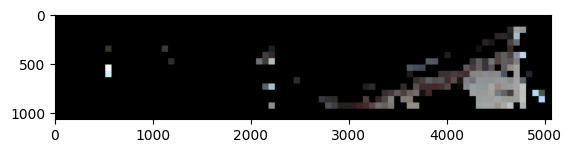

In [4]:
from matplotlib import pyplot as plt

plt.imshow(output_scene.detach().numpy().transpose(1, 0, 2))

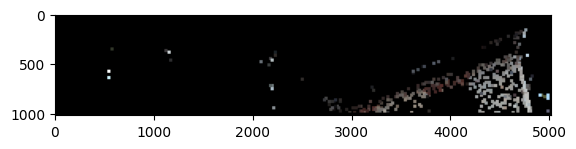

In [4]:
from matplotlib import pyplot as plt

plt.imshow(output_scene.detach().numpy().transpose(1, 0, 2))

In [10]:
output_scene.shape

torch.Size([5016, 1016, 3])

In [ ]:
truth = points

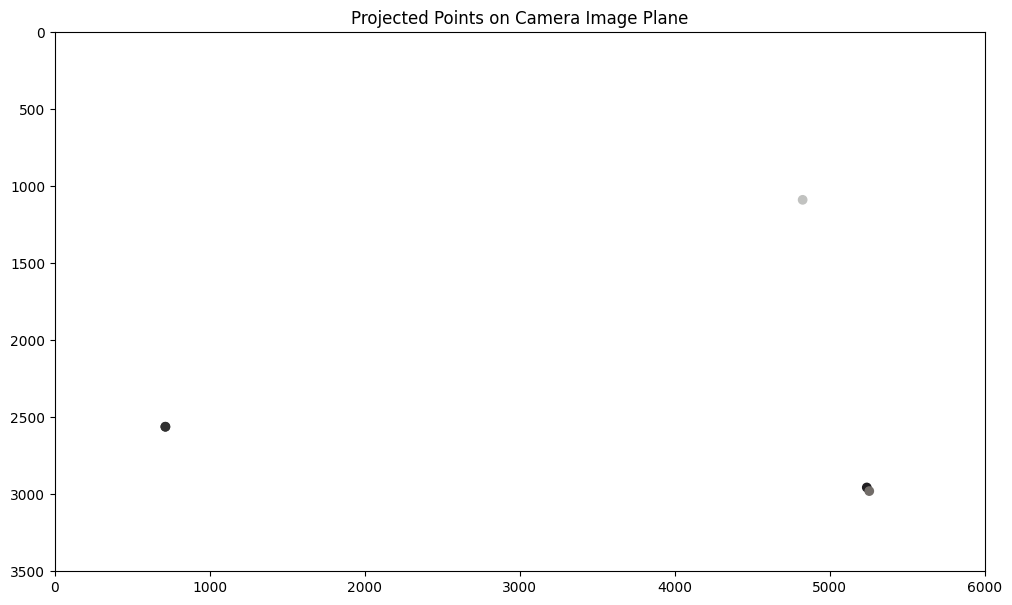

In [50]:
import numpy as np
import matplotlib.pyplot as plt
points2d = np.array(points.cpu().detach())
colors2d = np.array(scene.colors.cpu().detach())

# Plot points
plt.figure(figsize=(12, 7))
plt.scatter(points2d[:, 0], points2d[:, 1], c=colors2d[:5])
plt.xlim(0, 6000)
plt.ylim(0, 3500)
plt.gca().invert_yaxis()  # Invert the y-axis to match the image coordinates
plt.title('Projected Points on Camera Image Plane')
plt.show()
